In [83]:
import pandas as pd
import numpy as np

df = pd.read_csv('default_of_credit_card_clients.csv')

In [84]:
df.head()

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
2,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0


In [85]:
df.columns

Index(['Unnamed: 0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9',
       'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19',
       'X20', 'X21', 'X22', 'X23', 'Y'],
      dtype='object')

In [86]:
import pandas as pd

df = pd.read_csv("default_of_credit_card_clients.csv", header=1)  


In [87]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

In [88]:
df = df.rename(columns={'default payment next month': 'TARGET'})

In [89]:
columnas_a_convertir = df.columns.drop(['ID'])

In [90]:
for col in columnas_a_convertir:
        df[col] = pd.to_numeric(df[col], errors='coerce')

In [91]:
df = df.fillna(0)

In [ ]:
# --- 1. Ratios y Tendencias 


df['UTILIZATION_RATIO'] = (df['BILL_AMT1'] / df['LIMIT_BAL']).replace([np.inf, -np.inf], 0)
df['UTILIZATION_RATIO'] = np.clip(df['UTILIZATION_RATIO'], 0, 1.5)

# Calculamos promedio y velocidad
bill_cols = [f'BILL_AMT{i}' for i in range(1, 7)]
df['TOTAL_BILL_AMOUNT'] = df[bill_cols].sum(axis=1)
df['AVG_BILL'] = df[bill_cols].mean(axis=1)

# Creamos la velocidad y LIMPIAMOS INFINITOS 
df['SPENDING_VELOCITY'] = df['BILL_AMT1'] / (df['AVG_BILL'] + 1)



df = df.replace([np.inf, -np.inf], np.nan)
df = df.fillna(0) 

# Limitar outliers para estabilidad del modelo
df['SPENDING_VELOCITY'] = np.clip(df['SPENDING_VELOCITY'], 0, 100)

print("Features 'AVG_BILL' y 'SPENDING_VELOCITY' creadas y limpias.")

Features 'AVG_BILL' y 'SPENDING_VELOCITY' creadas y limpias.


In [93]:


pay_cols = [f'PAY_{i}' for i in range(0, 7) if f'PAY_{i}' in df.columns]


df['MAX_DELAY'] = df[pay_cols].max(axis=1)


df['MEAN_DELAY'] = df[pay_cols].mean(axis=1)

print("Features: 'MAX_DELAY' y 'MEAN_DELAY' creados.")

Features: 'MAX_DELAY' y 'MEAN_DELAY' creados.


In [94]:

# Pago del mes 1 (PAY_AMT1) en relación al saldo del mes 2 (BILL_AMT2)
df['PAYMENT_TO_BILL_RATIO'] = (df['PAY_AMT1'] / (df['BILL_AMT2'] + 1)).replace([np.inf, -np.inf], 0)
df['PAYMENT_TO_BILL_RATIO'] = np.clip(df['PAYMENT_TO_BILL_RATIO'], 0, 2) # Limitamos a un máximo de 2x
print("Feature: 'PAYMENT_TO_BILL_RATIO' creado.")


df = df.fillna(0)

# Guardar el DataFrame con las nuevas características
df.to_csv('datos_crediticios_FE.csv', index=False)
print("\n--- Feature Engineering completado. Guardado en 'datos_crediticios_FE.csv'. ---")
print(f"Dimensiones finales: {df.shape}")

Feature: 'PAYMENT_TO_BILL_RATIO' creado.

--- Feature Engineering completado. Guardado en 'datos_crediticios_FE.csv'. ---
Dimensiones finales: (30000, 32)


In [ ]:
# 1. Calcular variables
df['AVG_BILL'] = df[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].mean(axis=1)
df['SPENDING_VELOCITY'] = df['BILL_AMT1'] / (df['AVG_BILL'] + 1)

# 2. LIMPIEZA DE VALORES INFINITOS
# Reemplazamos infinitos por el valor máximo y los NaN por 0
df['SPENDING_VELOCITY'] = df['SPENDING_VELOCITY'].replace([np.inf, -np.inf], np.nan)
df['SPENDING_VELOCITY'] = df['SPENDING_VELOCITY'].fillna(0)

# 3. CAPEAR OUTLIERS (Opcional pero recomendado para XGBoost)
# Si alguien tiene una velocidad de gasto de 1,000,000x, romperá el modelo. 
# Limitamos a un máximo razonable (ej. 100x el promedio).
df['SPENDING_VELOCITY'] = df['SPENDING_VELOCITY'].clip(upper=100)

print(f"Valores infinitos corregidos. Máximo valor: {df['SPENDING_VELOCITY'].max()}")

Valores infinitos corregidos. Máximo valor: 100.0


In [ ]:
import numpy as np
import pandas as pd

def calculate_woe_iv(df, feature, target_col='TARGET'):
    """
    Calcula el WOE y el IV convirtiendo primero a string 
    para evitar errores de categorías cerradas.
    """
    temp_df = df.copy()
    
    # 1. FORZAMOS la columna a string. 
    # Esto elimina el error "Cannot setitem on a Categorical"
    temp_df[feature] = temp_df[feature].astype(str)
    
    # 2. Reemplazamos nulos o textos 'nan' por 'Missing'
    temp_df[feature] = temp_df[feature].replace(['nan', 'None', 'NaN'], 'Missing')
    temp_df[feature] = temp_df[feature].fillna("Missing")
    
    # 3. Conteo de Buenos y Malos
    df_agg = temp_df.groupby(feature)[target_col].agg(['count', 'sum']).reset_index()
    df_agg.columns = [feature, 'Total', 'Bad']
    df_agg['Good'] = df_agg['Total'] - df_agg['Bad']
    
    # 4. Manejo de seguridad (Ajuste de Laplace)
    total_good = df_agg['Good'].sum()
    total_bad = df_agg['Bad'].sum()
    
    # Evitamos divisiones por cero sumando un pequeño valor
    df_agg['Prop_Good'] = (df_agg['Good'] + 0.5) / (total_good + 0.5)
    df_agg['Prop_Bad'] = (df_agg['Bad'] + 0.5) / (total_bad + 0.5)
    
    # 5. Cálculo de WOE e IV
    df_agg['WOE'] = np.log(df_agg['Prop_Good'] / df_agg['Prop_Bad'])
    df_agg['IV_Component'] = (df_agg['Prop_Good'] - df_agg['Prop_Bad']) * df_agg['WOE']
    
    iv_total = df_agg['IV_Component'].sum()
    df_agg['IV'] = iv_total
    
    return df_agg[[feature, 'Total', 'Good', 'Bad', 'Prop_Good', 'Prop_Bad', 'WOE', 'IV']].sort_values(by='WOE')
    


# --- BLOQUE DE LIMPIEZA PREVIA
# 1. Cálculo de variables
df['AVG_BILL'] = df[[f'BILL_AMT{i}' for i in range(1, 7)]].mean(axis=1)
df['SPENDING_VELOCITY'] = df['BILL_AMT1'] / (df['AVG_BILL'] + 1)

# 2. Reemplazar infinitos solo en las columnas numéricas
# Esto evita tocar las columnas "Categorical" que causan el error
cols_numericas = df.select_dtypes(include=[np.number]).columns
df[cols_numericas] = df[cols_numericas].replace([np.inf, -np.inf], np.nan)

# 3. Rellenar nulos solo en columnas numéricas con 0
df[cols_numericas] = df[cols_numericas].fillna(0)

# 4. Capear outliers en la nueva variable
df['SPENDING_VELOCITY'] = np.clip(df['SPENDING_VELOCITY'], 0, 100)

print(" Limpieza completada sin afectar columnas categóricas.")

# --- APLICACIÓN ---

print("--- Análisis de Variables Discretas ---")
pay0_iv_table = calculate_woe_iv(df, 'PAY_0')
print(f"**IV Total para PAY_0:** {pay0_iv_table['IV'].iloc[0]:.4f}")
display(pay0_iv_table)

print("\n--- Análisis de Nueva Variable (Velocity) ---")
df['VELOCITY_BINS'] = pd.qcut(df['SPENDING_VELOCITY'], q=5, duplicates='drop').astype(str)

velocity_iv_table = calculate_woe_iv(df, 'VELOCITY_BINS')
print(f"**IV Total para SPENDING_VELOCITY:** {velocity_iv_table['IV'].iloc[0]:.4f}")
display(velocity_iv_table)

✅ Limpieza completada sin afectar columnas categóricas.
--- Análisis de Variables Discretas ---
**IV Total para PAY_0:** 0.8772


,PAY_0,Total,Good,Bad,Prop_Good,Prop_Bad,WOE,IV
5,3,322,78,244,0.003360,0.036842,-2.394750,0.877158
9,7,9,2,7,0.000107,0.001130,-2.357245,0.877158
4,2,2667,823,1844,0.035246,0.277933,-2.065033,0.877158
6,4,76,24,52,0.001049,0.007911,-2.020773,0.877158
10,8,19,8,11,0.000364,0.001733,-1.560914,0.877158
8,6,11,5,6,0.000235,0.000979,-1.425687,0.877158
7,5,26,13,13,0.000578,0.002034,-1.258633,0.877158
3,1,3688,2436,1252,0.104282,0.188729,-0.593212,0.877158
0,-1,5686,4732,954,0.202551,0.143826,0.342388,0.877158
1,-2,2759,2394,365,0.102485,0.055074,0.621030,0.877158



--- Análisis de Nueva Variable (Velocity) ---
**IV Total para SPENDING_VELOCITY:** 0.0830


,VELOCITY_BINS,Total,Good,Bad,Prop_Good,Prop_Bad,WOE,IV
1,"(0.648, 0.957]",6000,4215,1785,0.180423,0.269042,-0.399563,0.083025
2,"(0.957, 1.118]",6000,4427,1573,0.189497,0.237098,-0.224100,0.083025
0,"(-0.001, 0.648]",6000,4832,1168,0.206831,0.176072,0.161010,0.083025
3,"(1.118, 1.497]",6003,4885,1118,0.209099,0.168538,0.215650,0.083025
4,"(1.497, 100.0]",5997,5005,992,0.214235,0.149552,0.359433,0.083025


In [ ]:
import pandas as pd
import numpy as np

# Cargar el DataFrame con las características de Feature Engineering
try:
    df = pd.read_csv('datos_crediticios_FE.csv')
except FileNotFoundError:
    print(" Error: No se encontró 'datos_crediticios_FE.csv'. Asegúrate de ejecutar los bloques anteriores.")
    
    raise

# Reafirmación de la función de cálculo de WOE/IV
def calculate_woe_iv(df, feature, target_col='TARGET'):
    df_agg = df.groupby(feature)[target_col].agg(['count', 'sum']).reset_index()
    df_agg.columns = [feature, 'Total', 'Bad']
    df_agg['Good'] = df_agg['Total'] - df_agg['Bad']
    
    df_agg['Prop_Good'] = df_agg['Good'] / df_agg['Good'].sum()
    df_agg['Prop_Bad'] = df_agg['Bad'] / df_agg['Bad'].sum()
    
    min_prop = 0.00001
    df_agg.loc[df_agg['Prop_Good'] == 0, 'Prop_Good'] = min_prop
    df_agg.loc[df_agg['Prop_Bad'] == 0, 'Prop_Bad'] = min_prop
    
    df_agg['WOE'] = np.log(df_agg['Prop_Good'] / df_agg['Prop_Bad'])
    df_agg['IV_Component'] = (df_agg['Prop_Good'] - df_agg['Prop_Bad']) * df_agg['WOE']
    df_agg['IV'] = df_agg['IV_Component'].sum()
    
    # Asegurar que los bins sean tratados como strings para la presentación
    if df_agg[feature].dtype.name == 'category':
        df_agg[feature] = df_agg[feature].astype(str)
        
    return df_agg[[feature, 'Total', 'Good', 'Bad', 'Prop_Good', 'Prop_Bad', 'WOE', 'IV']]

# --- 2. Aplicación a LIMIT_BAL (Límite de Crédito) ---

N_BINS = 10 
try:
    # 2.1. Binning por Cuantiles
    df['LIMIT_BAL_BINS'] = pd.qcut(
        df['LIMIT_BAL'], 
        q=N_BINS, 
        duplicates='drop', 
        precision=0 
    )
    
    # 2.2. Cálculo de WOE/IV para los nuevos bins
    limit_bal_woe_iv = calculate_woe_iv(df, 'LIMIT_BAL_BINS')
    limit_bal_woe_iv = limit_bal_woe_iv.sort_values(by='WOE') # Ordenamos por WOE para ver la monotonicidad
    
    print(f"\n Análisis de WOE/IV para LIMIT_BAL (Binning por {N_BINS} Cuantiles):")
    print(limit_bal_woe_iv)
    print(f"\n**IV Total para LIMIT_BAL:** {limit_bal_woe_iv['IV'].iloc[0]:.4f}")

except Exception as e:
    print(f"Error al aplicar qcut a LIMIT_BAL: {e}")


 Análisis de WOE/IV para LIMIT_BAL (Binning por 10 Cuantiles):
          LIMIT_BAL_BINS  Total  Good   Bad  Prop_Good  Prop_Bad       WOE  \
0      (9999.0, 30000.0]   4081  2618  1463   0.112053  0.220464 -0.676765   
2     (50000.0, 70000.0]   1556  1113   443   0.047637  0.066757 -0.337442   
1     (30000.0, 50000.0]   3595  2618   977   0.112053  0.147227 -0.273008   
3    (70000.0, 100000.0]   3266  2465   801   0.105504  0.120705 -0.134601   
4   (100000.0, 140000.0]   2792  2154   638   0.092193  0.096142 -0.041943   
6   (180000.0, 210000.0]   2487  2051   436   0.087785  0.065702  0.289754   
5   (140000.0, 180000.0]   3331  2753   578   0.117831  0.087101  0.302186   
7   (210000.0, 270000.0]   2934  2456   478   0.105119  0.072031  0.377992   
8   (270000.0, 360000.0]   3482  2954   528   0.126434  0.079566  0.463132   
9  (360000.0, 1000000.0]   2476  2182   294   0.093392  0.044304  0.745730   

         IV  
0  0.178139  
2  0.178139  
1  0.178139  
3  0.178139  
4  0.17

C:\Users\LKS\AppData\Local\Temp\ipykernel_14484\1612636095.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_agg = df.groupby(feature)[target_col].agg(['count', 'sum']).reset_index()


In [98]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

# 1. Cargar el DataFrame
try:
    df = pd.read_csv('datos_crediticios_FE.csv')
    df['TARGET'] = df['TARGET'].astype(int) 
except FileNotFoundError:
    print("Error: Asegúrate de que 'datos_crediticios_FE.csv' exista.")
    raise

# --- NUEVO: PREPARACIÓN DE VARIABLES CONTINUAS PARA WOE ---
# Para aplicar WOE a variables continuas, primero debemos binarlas (discretizarlas)

# A. Binar LIMIT_BAL si no existe
if 'LIMIT_BAL_BINS' not in df.columns:
    df['LIMIT_BAL_BINS'] = pd.qcut(df['LIMIT_BAL'], q=10, duplicates='drop', precision=0).astype(str)

# B. Binar SPENDING_VELOCITY (Nuestra variable Elite)
# Creamos 5 grupos: desde el que gasta mucho menos que su promedio hasta el que gasta mucho más
df['VELOCITY_BINS'] = pd.qcut(df['SPENDING_VELOCITY'], q=5, duplicates='drop', precision=2).astype(str)

# --- DEFINICIÓN DE CARACTERÍSTICAS PARA EL SCORECARD ---
WOE_FEATURES = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'LIMIT_BAL_BINS', 'VELOCITY_BINS']

# Función WOE/IV Robusta (con corrección para evitar infinitos)
def calculate_woe_iv(df, feature, target_col='TARGET'):
    df_agg = df.groupby(feature)[target_col].agg(['count', 'sum']).reset_index()
    df_agg.columns = [feature, 'Total', 'Bad']
    df_agg['Good'] = df_agg['Total'] - df_agg['Bad']
    
    # Suavizado de Laplace para evitar divisiones por cero o logs infinitos
    total_g = df_agg['Good'].sum()
    total_b = df_agg['Bad'].sum()
    
    df_agg['Prop_Good'] = (df_agg['Good'] + 0.5) / (total_g + 0.5)
    df_agg['Prop_Bad'] = (df_agg['Bad'] + 0.5) / (total_b + 0.5)
    
    df_agg['WOE'] = np.log(df_agg['Prop_Good'] / df_agg['Prop_Bad'])
    df_agg['IV_Component'] = (df_agg['Prop_Good'] - df_agg['Prop_Bad']) * df_agg['WOE']
    df_agg['IV'] = df_agg['IV_Component'].sum()
    return df_agg

# --- PROCESO DE TRANSFORMACIÓN ---
woe_mapping = {}

for feature in WOE_FEATURES:
    # 1. Calcular tabla WOE
    woe_table = calculate_woe_iv(df, feature, target_col='TARGET')
    
    # 2. Crear diccionario de mapeo
    woe_dict = woe_table.set_index(feature)['WOE'].to_dict()
    woe_mapping[feature] = woe_dict
    
    # 3. Aplicar transformación
    df[f'{feature}_WOE'] = df[feature].map(woe_dict)
    
    print(f"✅ Variable '{feature}' transformada. IV: {woe_table['IV'].iloc[0]:.4f}")

# 4. Definir conjunto final para Regresión Logística
X_WOE_FEATURES = [f'{feat}_WOE' for feat in WOE_FEATURES]
print(f"\nCaracterísticas WOE finales: {X_WOE_FEATURES}")

✅ Variable 'SEX' transformada. IV: 0.0092
✅ Variable 'EDUCATION' transformada. IV: 0.0382
✅ Variable 'MARRIAGE' transformada. IV: 0.0071
✅ Variable 'PAY_0' transformada. IV: 0.8772
✅ Variable 'LIMIT_BAL_BINS' transformada. IV: 0.1780
✅ Variable 'VELOCITY_BINS' transformada. IV: 0.0830

Características WOE finales: ['SEX_WOE', 'EDUCATION_WOE', 'MARRIAGE_WOE', 'PAY_0_WOE', 'LIMIT_BAL_BINS_WOE', 'VELOCITY_BINS_WOE']


In [99]:
# --- 1. División de Datos (Entrenamiento y Prueba) ---
X = df[X_WOE_FEATURES]
y = df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# --- 2. Entrenamiento del Modelo ---
model_lr = LogisticRegression(C=0.1, solver='liblinear', random_state=42)
model_lr.fit(X_train, y_train)

# --- 3. Evaluación del Modelo ---
y_pred_proba = model_lr.predict_proba(X_test)[:, 1] # Probabilidad de Default (Clase 1)
y_pred = model_lr.predict(X_test)

# Métrica clave en riesgo: ROC AUC (Área bajo la curva ROC)
auc_score = roc_auc_score(y_test, y_pred_proba)

print("\n=======================================================")
print(f"AUC Score (Regresión Logística WOE): {auc_score:.4f}")
print("=======================================================")

# Coeficientes del modelo (El 'peso' de cada variable en el Scorecard)
print("\n--- Pesos del Scorecard (Coeficientes de Regresión Logística) ---")
coefficients = pd.DataFrame({
    'Feature': X_WOE_FEATURES,
    'Coefficient': model_lr.coef_[0]
}).sort_values(by='Coefficient', ascending=False)
print(coefficients)

# Otras métricas
print("\n--- Reporte de Clasificación (Threshold 0.5) ---")
print(classification_report(y_test, y_pred))


AUC Score (Regresión Logística WOE): 0.7377

--- Pesos del Scorecard (Coeficientes de Regresión Logística) ---
              Feature  Coefficient
1       EDUCATION_WOE    -0.326033
5   VELOCITY_BINS_WOE    -0.421669
0             SEX_WOE    -0.485953
4  LIMIT_BAL_BINS_WOE    -0.659789
2        MARRIAGE_WOE    -0.725403
3           PAY_0_WOE    -0.938215

--- Reporte de Clasificación (Threshold 0.5) ---
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      7009
           1       0.69      0.33      0.44      1991

    accuracy                           0.82      9000
   macro avg       0.76      0.64      0.67      9000
weighted avg       0.80      0.82      0.79      9000



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import xgboost as xgb  
from sklearn.metrics import roc_auc_score, f1_score
import numpy as np
import joblib

try:
    df = pd.read_csv('datos_crediticios_FE.csv')
    df['TARGET'] = df['TARGET'].astype(int) 
except FileNotFoundError:
    print("Error: Asegúrate de que 'datos_crediticios_FE.csv' exista.")
    raise

# --- NUEVA FEATURE ENGINEERING ---
df['AVG_BILL'] = df[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].mean(axis=1)
df['SPENDING_VELOCITY'] = df['BILL_AMT1'] / (df['AVG_BILL'] + 1)

# --- BLOQUE DE LIMPIEZA 
# Reemplazamos infinitos y NaN solo en columnas numéricas para evitar el TypeError de las categorías
cols_num = df.select_dtypes(include=[np.number]).columns
df[cols_num] = df[cols_num].replace([np.inf, -np.inf], np.nan)
df[cols_num] = df[cols_num].fillna(0)
df['SPENDING_VELOCITY'] = np.clip(df['SPENDING_VELOCITY'], 0, 100)

FEATURES = [
    'LIMIT_BAL', 'AGE', 'SEX', 'EDUCATION', 'MARRIAGE', 
    'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 
    'TOTAL_BILL_AMOUNT', 'MAX_DELAY', 'UTILIZATION_RATIO', 
    'PAYMENT_TO_BILL_RATIO',
    'AVG_BILL',           
    'SPENDING_VELOCITY'    
]
TARGET = 'TARGET'

# --- 1. Monotonic Constraints ---
MONOTONIC_CONSTRAINTS = []
for feature in FEATURES:
    if feature in ['LIMIT_BAL', 'AGE']:
        MONOTONIC_CONSTRAINTS.append(-1) 
    elif feature in ['MAX_DELAY', 'UTILIZATION_RATIO', 'SPENDING_VELOCITY']:
        MONOTONIC_CONSTRAINTS.append(1) 
    else:
        MONOTONIC_CONSTRAINTS.append(0) 

# --- 2. División de Datos ---
X = df[FEATURES]
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# --- 3. Entrenamiento ---
# Si usas XGBoost en el bucle después de esto, ya no fallará porque X_train está limpio.
model = lgb.LGBMClassifier(
    monotonic_constraints=MONOTONIC_CONSTRAINTS,
    n_estimators=100,
    random_state=42
)
model.fit(X_train, y_train)

# --- 4. GUARDAR EL MODELO ---
joblib.dump(model, 'model_lgbm_monotonic.pkl')
print("✅ Datos limpiados y modelo guardado exitosamente.")

[LightGBM] [Warning] Unknown parameter: monotonic_constraints
[LightGBM] [Warning] Unknown parameter: monotonic_constraints
[LightGBM] [Info] Number of positive: 4645, number of negative: 16355
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1488
[LightGBM] [Info] Number of data points in the train set: 21000, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221190 -> initscore=-1.258742
[LightGBM] [Info] Start training from score -1.258742
✅ Datos limpiados y modelo guardado exitosamente.


In [ ]:
# --- 3. Entrenamiento de LightGBM ---

# Parámetros del modelo (ajustados para un buen balance entre rendimiento y velocidad)
lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': 6,
    'n_jobs': -1,
    'seed': 42,
    
    'monotone_constraints': MONOTONIC_CONSTRAINTS,
    'monotone_pool': True # Permite que el modelo relaje las restricciones si es necesario
}

model_lgb = lgb.LGBMClassifier(**lgb_params)

# Usamos early stopping para evitar overfitting
model_lgb.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='auc',
    callbacks=[lgb.early_stopping(100, verbose=False)]
)

print(" Entrenamiento de LightGBM completado con Monotonic Constraints.")

[LightGBM] [Warning] Unknown parameter: monotone_pool
[LightGBM] [Warning] Unknown parameter: monotone_pool
[LightGBM] [Info] Number of positive: 4645, number of negative: 16355
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1488
[LightGBM] [Info] Number of data points in the train set: 21000, number of used features: 17
[LightGBM] [Warning] Unknown parameter: monotone_pool
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221190 -> initscore=-1.258742
[LightGBM] [Info] Start training from score -1.258742
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

In [109]:
import joblib
import os
from pathlib import Path # Excelente para manejo de rutas en Python


RUTA_BASE = Path.home() / "Desktop" 
NOMBRE_ARCHIVO = 'model_lgbm_monotonic.pkl'
RUTA_FINAL = RUTA_BASE / NOMBRE_ARCHIVO


RUTA_FINAL.parent.mkdir(parents=True, exist_ok=True)


try:
    joblib.dump(model_lgb, RUTA_FINAL)
    print(f"\n Modelo LightGBM guardado exitosamente en: {RUTA_FINAL}")
except Exception as e:
    print(f" Falló incluso con ruta absoluta: {e}")


 Modelo LightGBM guardado exitosamente en: C:\Users\LKS\Desktop\model_lgbm_monotonic.pkl


✅ Modelo 'LGBMClassifier' cargado exitosamente.


c:\Users\LKS\AppData\Local\Programs\Python\Python311\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


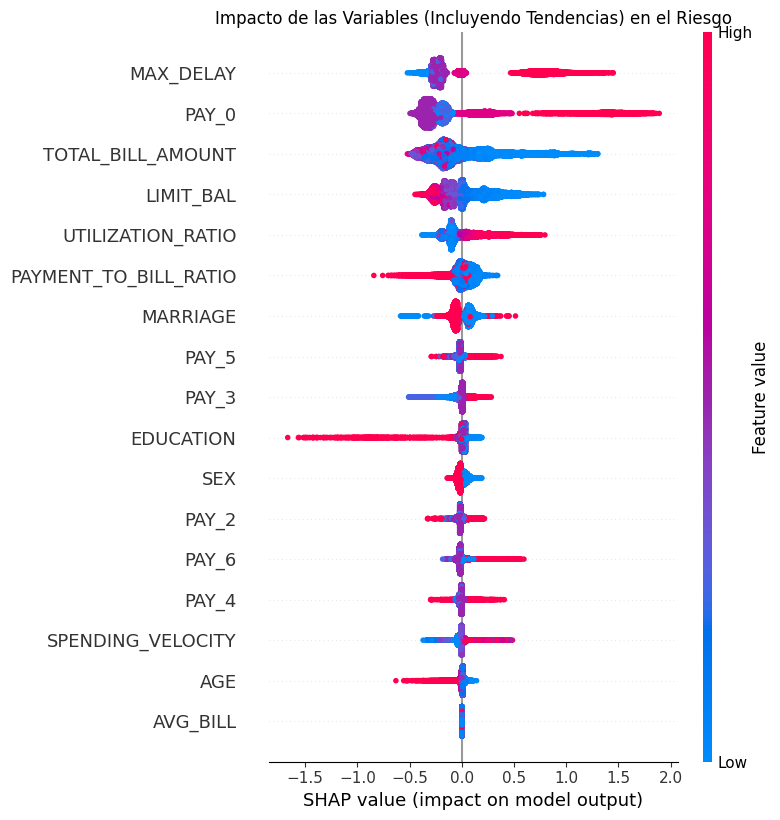

In [ ]:
import joblib
import shap
import pandas as pd
import matplotlib.pyplot as plt


nombre_archivo = 'model_lgbm_monotonic.pkl'

try:
    model = joblib.load(nombre_archivo)
    print(f"✅ Modelo '{type(model).__name__}' cargado exitosamente.")
except FileNotFoundError:
    print(f"❌ ERROR: No se encontró el archivo '{nombre_archivo}'.")
    raise 

# 2. Cargar datos y REPLICAR la ingeniería de variables
df = pd.read_csv('datos_crediticios_FE.csv')

# --- IMPORTANTE: Debemos crear las mismas columnas que vio el modelo ---
df['AVG_BILL'] = df[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].mean(axis=1)
df['SPENDING_VELOCITY'] = df['BILL_AMT1'] / (df['AVG_BILL'] + 1)

# Lista de características completa (17 variables)
FEATURES = [
    'LIMIT_BAL', 'AGE', 'SEX', 'EDUCATION', 'MARRIAGE', 
    'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 
    'TOTAL_BILL_AMOUNT', 'MAX_DELAY', 'UTILIZATION_RATIO', 
    'PAYMENT_TO_BILL_RATIO',
    'AVG_BILL',           
    'SPENDING_VELOCITY'    
]

X = df[FEATURES]

# 3. Explicabilidad con SHAP
explainer = shap.TreeExplainer(model)
# Calculamos los valores SHAP 
shap_values = explainer.shap_values(X)

# 4. Visualización: Summary Plot
plt.figure(figsize=(10, 8))
plt.title("Impacto de las Variables (Incluyendo Tendencias) en el Riesgo")

# En LightGBM, shap_values puede ser una lista (clase 0, clase 1) 
# o un array. Si da error, usa shap_values[1] para la probabilidad de default.
shap.summary_plot(shap_values, X)

In [111]:
y_pd = model.predict_proba(X)[:, 1]

df_finance = pd.DataFrame({
    'ID': df.index,
    'PD': y_pd,
    'EAD': df['BILL_AMT1'],  # Exposición: Saldo actual
    'LIMIT_BAL': df['LIMIT_BAL'] # Límite de crédito para comparar
})

# 3. Definir LGD (Loss Given Default) - Supuesto del 75%
LGD = 0.75

# 4. Calcular la Pérdida Esperada (EL)
df_finance['EL'] = df_finance['PD'] * df_finance['EAD'] * LGD

# 5. Segmentación por Riesgo (Credit Rating Simulado)
def assign_rating(pd):
    if pd <= 0.05: return 'A (Bajo Riesgo)'
    if pd <= 0.15: return 'B (Riesgo Medio)'
    if pd <= 0.40: return 'C (Riesgo Alto)'
    return 'D (Default Inminente)'

df_finance['Rating'] = df_finance['PD'].apply(assign_rating)

# --- 6. Resumen Ejecutivo de Pérdidas ---
resumen_el = df_finance.groupby('Rating').agg({
    'ID': 'count',
    'EAD': 'sum',
    'EL': 'sum'
}).rename(columns={'ID': 'Cant_Clientes', 'EAD': 'Exposicion_Total', 'EL': 'Perdida_Esperada_Total'})

# Calcular el porcentaje de pérdida sobre la exposición
resumen_el['%_Perdida'] = (resumen_el['Perdida_Esperada_Total'] / resumen_el['Exposicion_Total']) * 100

print(" RESUMEN DE PÉRDIDA ESPERADA POR SEGMENTO:")
print(resumen_el)

print(f"\n PÉRDIDA ESPERADA TOTAL DE LA CARTERA: ${df_finance['EL'].sum():,.2f}")

[LightGBM] [Warning] Unknown parameter: monotone_pool
 RESUMEN DE PÉRDIDA ESPERADA POR SEGMENTO:
                       Cant_Clientes  Exposicion_Total  \
Rating                                                   
A (Bajo Riesgo)                 2436         167023086   
B (Riesgo Medio)               12726         767090585   
C (Riesgo Alto)                10410         364793445   
D (Default Inminente)           4428         237792811   

                       Perdida_Esperada_Total  %_Perdida  
Rating                                                    
A (Bajo Riesgo)                  5.139672e+06   3.077223  
B (Riesgo Medio)                 5.594546e+07   7.293201  
C (Riesgo Alto)                  5.943311e+07  16.292265  
D (Default Inminente)            1.190426e+08  50.061489  

 PÉRDIDA ESPERADA TOTAL DE LA CARTERA: $239,560,867.09


In [112]:
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
import time

# 1. Definir modelos
models = {
    "LightGBM (Nuestro)": LGBMClassifier(monotonic_constraints=[(1 if col in ['PAY_0', 'MAX_DELAY'] else 0) for col in FEATURES]),
    "XGBoost (Benchmark)": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

results = []

# 2. Entrenar y medir
for name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    
    preds_proba = model.predict_proba(X_test)[:, 1]
    preds = model.predict(X_test)
    
    results.append({
        "Modelo": name,
        "AUC": roc_auc_score(y_test, preds_proba),
        "F1-Score": f1_score(y_test, preds),
        "Accuracy": accuracy_score(y_test, preds),
        "Tiempo de Entrenamiento (s)": round(end_time - start_time, 4)
    })

# 3. Mostrar tabla comparativa
df_results = pd.DataFrame(results)
print("📊 COMPARATIVA DE MODELOS:")
display(df_results)

[LightGBM] [Warning] Unknown parameter: monotonic_constraints
[LightGBM] [Warning] Unknown parameter: monotonic_constraints
[LightGBM] [Info] Number of positive: 4645, number of negative: 16355
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000909 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1488
[LightGBM] [Info] Number of data points in the train set: 21000, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221190 -> initscore=-1.258742
[LightGBM] [Info] Start training from score -1.258742
[LightGBM] [Warning] Unknown parameter: monotonic_constraints
[LightGBM] [Warning] Unknown parameter: monotonic_constraints
📊 COMPARATIVA DE MODELOS:


c:\Users\LKS\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:02:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


,Modelo,AUC,F1-Score,Accuracy,Tiempo de Entrenamiento (s)
0,LightGBM (Nuestro),0.776622,0.465753,0.818000,0.2030
1,XGBoost (Benchmark),0.766292,0.463970,0.811556,0.1892


C:\Users\LKS\AppData\Local\Temp\ipykernel_14484\4280684779.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='SEX', y='PROB', data=fairness_check, palette='viridis')
c:\Users\LKS\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\LKS\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:1273: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude th

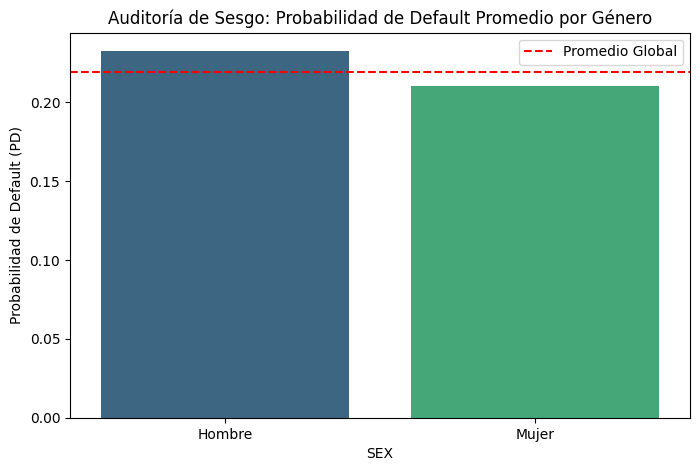

Tasa de aprobación Hombres: 60.93%
Tasa de aprobación Mujeres: 66.03%
Ratio de Impacto Dispar: 1.08


In [113]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Obtener predicciones para el set de prueba
test_df = pd.DataFrame(X_test, columns=FEATURES)
test_df['PROB'] = model.predict_proba(X_test)[:, 1]
test_df['SEX'] = test_df['SEX'].astype(int)

# 2. Calcular Probabilidad Promedio por Género
fairness_check = test_df.groupby('SEX')['PROB'].mean().reset_index()
fairness_check['SEX'] = fairness_check['SEX'].map({1: 'Hombre', 2: 'Mujer'})

# 3. Visualización
plt.figure(figsize=(8, 5))
sns.barplot(x='SEX', y='PROB', data=fairness_check, palette='viridis')
plt.title("Auditoría de Sesgo: Probabilidad de Default Promedio por Género")
plt.ylabel("Probabilidad de Default (PD)")
plt.axhline(test_df['PROB'].mean(), color='red', linestyle='--', label='Promedio Global')
plt.legend()
plt.show()

# 4. Métrica de Impacto Dispar (Disparate Impact)
# Tasa de aprobación (Prob < 0.20)
hombres_aprobados = len(test_df[(test_df['SEX'] == 1) & (test_df['PROB'] < 0.20)]) / len(test_df[test_df['SEX'] == 1])
mujeres_aprobadas = len(test_df[(test_df['SEX'] == 2) & (test_df['PROB'] < 0.20)]) / len(test_df[test_df['SEX'] == 2])

print(f"Tasa de aprobación Hombres: {hombres_aprobados:.2%}")
print(f"Tasa de aprobación Mujeres: {mujeres_aprobadas:.2%}")
print(f"Ratio de Impacto Dispar: {mujeres_aprobadas / hombres_aprobados:.2f}")

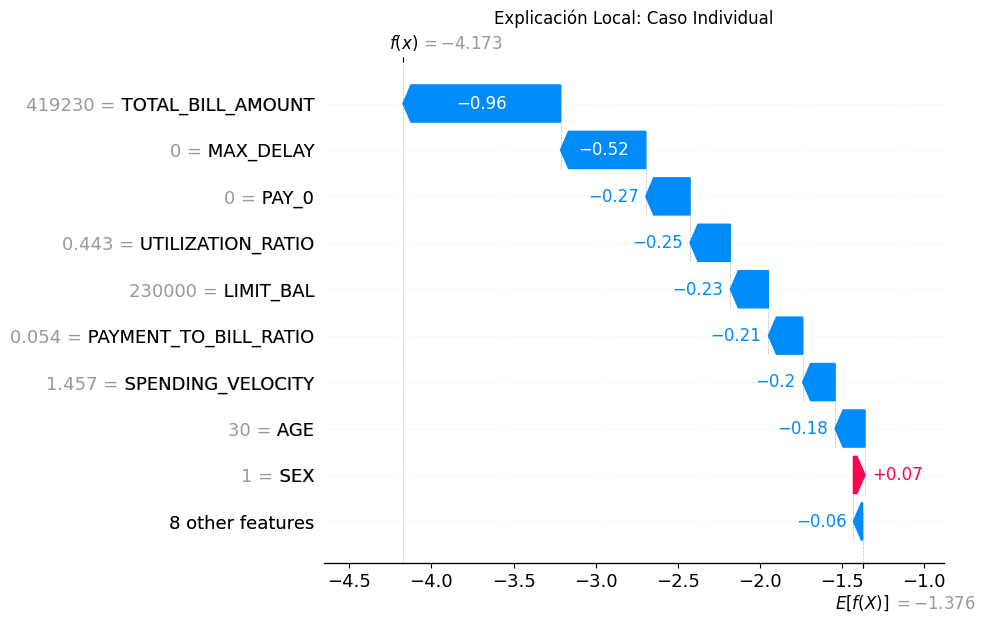

In [ ]:
import shap

# 1. Crear el objeto de explicación para un individuo 
explainer = shap.TreeExplainer(model)
shap_values_individual = explainer(X_test)

# 2. Visualizar el primer cliente (index 0)
# Esto muestra cómo el valor base (promedio) se mueve hacia la predicción final
plt.title("Explicación Local: Caso Individual")
shap.plots.waterfall(shap_values_individual[0])